<a href="https://colab.research.google.com/github/hasdasda/HoctheoPhamDinhKhanh/blob/main/Inference_with_Table_Transformer_(TATR)_for_parsing_tables.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Set-up environment

Let's start by installing 🤗 Transformers and [EasyOCR](https://github.com/JaidedAI/EasyOCR) (an open-source OCR engine). Google Colab already comes with Transformers pre-installed.

In [20]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [21]:
!pip install -q transformers
!pip install -q vietocr

In [22]:
!pip install --upgrade pillow

  Using cached pillow-11.0.0-cp310-cp310-manylinux_2_28_x86_64.whl.metadata (9.1 kB)
Using cached pillow-11.0.0-cp310-cp310-manylinux_2_28_x86_64.whl (4.4 MB)
  Attempting uninstall: pillow
    Found existing installation: pillow 10.2.0
    Uninstalling pillow-10.2.0:
      Successfully uninstalled pillow-10.2.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
vietocr 0.3.13 requires pillow==10.2.0, but you have pillow 11.0.0 which is incompatible.


In [23]:
# Just right before the actual usage
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

## Load model

Next, we load a Table Transformer pre-trained for table detection. We use the "no_timm" version here to load the checkpoint with a Transformers-native backbone.

In [24]:
from transformers import AutoModelForObjectDetection

model = AutoModelForObjectDetection.from_pretrained("microsoft/table-transformer-detection", revision="no_timm")

In [25]:
model.config.id2label

{0: 'table', 1: 'table rotated'}

We move the model to a GPU if it's available (predictions will be faster).

In [26]:
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
print("")

In [27]:
# import streamlit as st
# from transformers import AutoModelForObjectDetection, TableTransformerForObjectDetection
# from huggingface_hub import hf_hub_download
# import torch
# from PIL import Image, ImageDraw
# from torchvision import transforms
# import matplotlib.pyplot as plt
# import matplotlib.patches as patches
# from matplotlib.patches import Patch
# import pandas as pd
# import numpy as np
# from vietocr.tool.predictor import Predictor
# from vietocr.tool.config import Cfg
# import csv
# from tqdm.auto import tqdm

# # Setup
# device = "cuda" if torch.cuda.is_available() else "cpu"

# # Load models
# @st.cache_resource
# def load_models():
#     detection_model = AutoModelForObjectDetection.from_pretrained("microsoft/table-transformer-detection", revision="no_timm").to(device)
#     structure_model = TableTransformerForObjectDetection.from_pretrained("microsoft/table-structure-recognition-v1.1-all").to(device)
#     return detection_model, structure_model

# detection_model, structure_model = load_models()

# # Define image transformations
# class MaxResize(object):
#     def __init__(self, max_size=800):
#         self.max_size = max_size

#     def __call__(self, image):
#         width, height = image.size
#         current_max_size = max(width, height)
#         scale = self.max_size / current_max_size
#         resized_image = image.resize((int(round(scale * width)), int(round(scale * height))))
#         return resized_image

# detection_transform = transforms.Compose([
#     MaxResize(800),
#     transforms.ToTensor(),
#     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
# ])

# structure_transform = transforms.Compose([
#     MaxResize(1000),
#     transforms.ToTensor(),
#     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
# ])

# # Upload image
# st.title("Table Information Extraction")
# uploaded_file = st.file_uploader("Choose an image file", type=["png", "jpg", "jpeg"])
# if uploaded_file:
#     image = Image.open(uploaded_file).convert("RGB")
#     st.image(image, caption='Uploaded Image', use_column_width=True)

#     # Process image
#     pixel_values = detection_transform(image).unsqueeze(0).to(device)
#     with torch.no_grad():
#         outputs = detection_model(pixel_values)

#     # Define id2label
#     id2label = detection_model.config.id2label
#     id2label[len(detection_model.config.id2label)] = "no object"

#     # Functions for post-processing
#     def box_cxcywh_to_xyxy(x):
#         x_c, y_c, w, h = x.unbind(-1)
#         b = [(x_c - 0.5 * w), (y_c - 0.5 * h), (x_c + 0.5 * w), (y_c + 0.5 * h)]
#         return torch.stack(b, dim=1)

#     def rescale_bboxes(out_bbox, size):
#         img_w, img_h = size
#         b = box_cxcywh_to_xyxy(out_bbox)
#         b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
#         return b

#     def outputs_to_objects(outputs, img_size, id2label):
#         m = outputs.logits.softmax(-1).max(-1)
#         pred_labels = list(m.indices.detach().cpu().numpy())[0]
#         pred_scores = list(m.values.detach().cpu().numpy())[0]
#         pred_bboxes = outputs['pred_boxes'].detach().cpu()[0]
#         pred_bboxes = [elem.tolist() for elem in rescale_bboxes(pred_bboxes, img_size)]

#         objects = []
#         for label, score, bbox in zip(pred_labels, pred_scores, pred_bboxes):
#             class_label = id2label[int(label)]
#             if not class_label == 'no object':
#                 objects.append({'label': class_label, 'score': float(score), 'bbox': [float(elem) for elem in bbox]})
#         return objects

#     objects = outputs_to_objects(outputs, image.size, id2label)

#     # Visualize detection
#     def visualize_detected_tables(img, det_tables):
#         plt.imshow(img, interpolation="lanczos")
#         fig = plt.gcf()
#         fig.set_size_inches(20, 20)
#         ax = plt.gca()

#         for det_table in det_tables:
#             bbox = det_table['bbox']
#             if det_table['label'] == 'table':
#                 facecolor = (1, 0, 0.45)
#                 edgecolor = (1, 0, 0.45)
#                 alpha = 0.3
#                 linewidth = 2
#                 hatch = '//////'
#             elif det_table['label'] == 'table rotated':
#                 facecolor = (0.95, 0.6, 0.1)
#                 edgecolor = (0.95, 0.6, 0.1)
#                 alpha = 0.3
#                 linewidth = 2
#                 hatch = '//////'
#             else:
#                 continue
#             rect = patches.Rectangle(bbox[:2], bbox[2] - bbox[0], bbox[3] - bbox[1], linewidth=linewidth,
#                                      edgecolor='none', facecolor=facecolor, alpha=0.1)
#             ax.add_patch(rect)
#             rect = patches.Rectangle(bbox[:2], bbox[2] - bbox[0], bbox[3] - bbox[1], linewidth=linewidth,
#                                      edgecolor=edgecolor, facecolor='none', linestyle='-', alpha=alpha)
#             ax.add_patch(rect)
#             rect = patches.Rectangle(bbox[:2], bbox[2] - bbox[0], bbox[3] - bbox[1], linewidth=0,
#                                      edgecolor=edgecolor, facecolor='none', linestyle='-', hatch=hatch, alpha=0.2)
#             ax.add_patch(rect)

#         plt.xticks([], [])
#         plt.yticks([], [])

#         legend_elements = [Patch(facecolor=(1, 0, 0.45), edgecolor=(1, 0, 0.45),
#                                  label='Table', hatch='//////', alpha=0.3),
#                            Patch(facecolor=(0.95, 0.6, 0.1), edgecolor=(0.95, 0.6, 0.1),
#                                  label='Table (rotated)', hatch='//////', alpha=0.3)]
#         plt.legend(handles=legend_elements, bbox_to_anchor=(0.5, -0.02), loc='upper center', borderaxespad=0,
#                    fontsize=10, ncol=2)
#         plt.axis('off')
#         return fig

#     fig = visualize_detected_tables(image, objects)
#     st.pyplot(fig)

#     # Extract table crops
#     def objects_to_crops(img, tokens, objects, class_thresholds, padding=10):
#         table_crops = []
#         for obj in objects:
#             if obj['score'] < class_thresholds[obj['label']]:
#                 continue

#             cropped_table = {}
#             bbox = obj['bbox']
#             bbox = [bbox[0] - padding, bbox[1] - padding, bbox[2] + padding, bbox[3] + padding]
#             cropped_img = img.crop(bbox)

#             table_tokens = [token for token in tokens if iob(token['bbox'], bbox) >= 0.5]
#             for token in table_tokens:
#                 token['bbox'] = [token['bbox'][0] - bbox[0],
#                                  token['bbox'][1] - bbox[1],
#                                  token['bbox'][2] - bbox[0],
#                                  token['bbox'][3] - bbox[1]]

#             if obj['label'] == 'table rotated':
#                 cropped_img = cropped_img.rotate(270, expand=True)
#                 for token in table_tokens:
#                     bbox = token['bbox']
#                     bbox = [cropped_img.size[0] - bbox[3] - 1,
#                             bbox[0],
#                             cropped_img.size[0] - bbox[1] - 1,
#                             bbox[2]]
#                     token['bbox'] = bbox

#             cropped_table['image'] = cropped_img
#             cropped_table['tokens'] = table_tokens
#             table_crops.append(cropped_table)
#         return table_crops

#     detection_class_thresholds = {
#         "table": 0.5,
#         "table rotated": 0.5,
#         "no object": 10
#     }
#     tables_crops = objects_to_crops(image, [], objects, detection_class_thresholds, padding=0)
#     if tables_crops:
#         cropped_table = tables_crops[0]['image'].convert("RGB")
#         st.image(cropped_table, caption='Cropped Table Image', use_column_width=True)

#         # Process cropped table image for cell detection
#         pixel_values = structure_transform(cropped_table).unsqueeze(0).to(device)
#         with torch.no_grad():
#             outputs = structure_model(pixel_values)

#         structure_id2label = structure_model.config.id2label
#         structure_id2label[len(structure_model.config.id2label)] = "no object"
#         cells = outputs_to_objects(outputs, cropped_table.size, structure_id2label)

#         cropped_table_visualized = cropped_table.copy()
#         draw = ImageDraw.Draw(cropped_table_visualized)
#         for cell in cells:
#             draw.rectangle(cell["bbox"], outline="red")
#         st.image(cropped_table_visualized, caption='Detected Cells', use_column_width=True)

#         # Define VietOCR predictor
#         config = Cfg.load_config_from_name('vgg_transformer')
#         config['cnn']['pretrained'] = False
#         config['device'] = 'cuda:0'
#         predictor = Predictor(config)

#         # Apply OCR to detected cells
#         def apply_vietocr(cell_coordinates):
#             data = dict()
#             max_num_columns = 0
#             for idx, row in enumerate(tqdm(cell_coordinates)):
#                 row_text = []
#                 for cell in row["cells"]:
#                     cell_image = np.array(cropped_table.crop(cell["cell"]))
#                     cell_image = Image.fromarray(cell_image)
#                     text = predictor.predict(cell_image)
#                     if text:
#                         row_text.append(text)
#                 if len(row_text) > max_num_columns:
#                     max_num_columns = len(row_text)
#                 data[idx] = row_text

#             for row, row_data in data.copy().items():
#                 if len(row_data) != max_num_columns:
#                     row_data = row_data + ["" for _ in range(max_num_columns - len(row_data))]
#                 data[row] = row_data
#             return data

#         def get_cell_coordinates_by_row(table_data):
#             rows = [entry for entry in table_data if entry['label'] == 'table row']
#             columns = [entry for entry in table_data if entry['label'] == 'table column']

#             rows.sort(key=lambda x: x['bbox'][1])
#             columns.sort(key=lambda x: x['bbox'][0])

#             def find_cell_coordinates(row, column):
#                 cell_bbox = [column['bbox'][0], row['bbox'][1], column['bbox'][2], row['bbox'][3]]
#                 return cell_bbox

#             cell_coordinates = []
#             for row in rows:
#                 row_cells = []
#                 for column in columns:
#                     cell_bbox = find_cell_coordinates(row, column)
#                     row_cells.append({'column': column['bbox'], 'cell': cell_bbox})

#                 row_cells.sort(key=lambda x: x['column'][0])
#                 cell_coordinates.append({'row': row['bbox'], 'cells': row_cells, 'cell_count': len(row_cells)})

#             cell_coordinates.sort(key=lambda x: x['row'][1])
#             return cell_coordinates

#         cell_coordinates = get_cell_coordinates_by_row(cells)
#         data = apply_vietocr(cell_coordinates)

#         # Display OCR results
#         st.write("Extracted Table Data:")
#         st.dataframe(pd.DataFrame.from_dict(data, orient='index'))

#         # Download CSV
#         if st.button('Download CSV'):
#             csv_file = 'output.csv'
#             with open(csv_file, 'w') as result_file:
#                 wr = csv.writer(result_file, dialect='excel')
#                 for row, row_text in data.items():
#                     wr.writerow(row_text)
#             st.success('CSV file created!')
#             with open(csv_file, 'rb') as file:
#                 st.download_button(
#                     label="Download CSV",
#                     data=file,
#                     file_name="output.csv",
#                     mime="text/csv",
#                 )


In [28]:
#!pip install streamlit

## Load image

Next, we can load a PDF image.

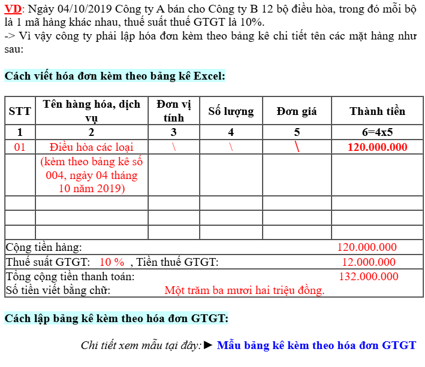

In [44]:
from PIL import Image
from huggingface_hub import hf_hub_download

# let's load an example image
file_path = "/content/Screenshot 2024-12-31 112037.png"
image = Image.open(file_path).convert("RGB")
# let's display it a bit smaller
width, height = image.size
display(image.resize((int(0.6*width), (int(0.6*height)))))

## Prepare image for the model

Preparing the image for the model can be done as follows:

In [45]:
from torchvision import transforms

class MaxResize(object):
    def __init__(self, max_size=800):
        self.max_size = max_size

    def __call__(self, image):
        width, height = image.size
        current_max_size = max(width, height)
        scale = self.max_size / current_max_size
        resized_image = image.resize((int(round(scale*width)), int(round(scale*height))))

        return resized_image

detection_transform = transforms.Compose([
    MaxResize(800),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [46]:
pixel_values = detection_transform(image).unsqueeze(0)
pixel_values = pixel_values.to(device)
print(pixel_values.shape)

torch.Size([1, 3, 692, 800])


## Forward pass

Next, we forward the pixel values through the model. The model outputs logits of shape (batch_size, num_queries, num_labels + 1). The +1 is for the "no object" class.

In [47]:
import torch

with torch.no_grad():
  outputs = model(pixel_values)

In [48]:
outputs.logits.shape

torch.Size([1, 15, 3])

## Postprocessing

Next, we take the prediction that has an actual class (i.e. not "no object").

In [49]:
# for output bounding box post-processing
def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(-1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h), (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)


def rescale_bboxes(out_bbox, size):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
    return b


# update id2label to include "no object"
id2label = model.config.id2label
id2label[len(model.config.id2label)] = "no object"


def outputs_to_objects(outputs, img_size, id2label):
    m = outputs.logits.softmax(-1).max(-1)
    pred_labels = list(m.indices.detach().cpu().numpy())[0]
    pred_scores = list(m.values.detach().cpu().numpy())[0]
    pred_bboxes = outputs['pred_boxes'].detach().cpu()[0]
    pred_bboxes = [elem.tolist() for elem in rescale_bboxes(pred_bboxes, img_size)]

    objects = []
    for label, score, bbox in zip(pred_labels, pred_scores, pred_bboxes):
        class_label = id2label[int(label)]
        if not class_label == 'no object':
            objects.append({'label': class_label, 'score': float(score),
                            'bbox': [float(elem) for elem in bbox]})

    return objects

In [50]:
objects = outputs_to_objects(outputs, image.size, id2label)

In [51]:
print(objects)

[{'label': 'table', 'score': 0.9992853999137878, 'bbox': [15.006417274475098, 165.96971130371094, 680.4815673828125, 389.18621826171875]}]


## Visualize

We can visualize the detection on the image.

In [52]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import Patch

def fig2img(fig):
    """Convert a Matplotlib figure to a PIL Image and return it"""
    import io
    buf = io.BytesIO()
    fig.savefig(buf)
    buf.seek(0)
    img = Image.open(buf)
    return img


def visualize_detected_tables(img, det_tables, out_path=None):
    plt.imshow(img, interpolation="lanczos")
    fig = plt.gcf()
    fig.set_size_inches(20, 20)
    ax = plt.gca()

    for det_table in det_tables:
        bbox = det_table['bbox']

        if det_table['label'] == 'table':
            facecolor = (1, 0, 0.45)
            edgecolor = (1, 0, 0.45)
            alpha = 0.3
            linewidth = 2
            hatch='//////'
        elif det_table['label'] == 'table rotated':
            facecolor = (0.95, 0.6, 0.1)
            edgecolor = (0.95, 0.6, 0.1)
            alpha = 0.3
            linewidth = 2
            hatch='//////'
        else:
            continue

        rect = patches.Rectangle(bbox[:2], bbox[2]-bbox[0], bbox[3]-bbox[1], linewidth=linewidth,
                                    edgecolor='none',facecolor=facecolor, alpha=0.1)
        ax.add_patch(rect)
        rect = patches.Rectangle(bbox[:2], bbox[2]-bbox[0], bbox[3]-bbox[1], linewidth=linewidth,
                                    edgecolor=edgecolor,facecolor='none',linestyle='-', alpha=alpha)
        ax.add_patch(rect)
        rect = patches.Rectangle(bbox[:2], bbox[2]-bbox[0], bbox[3]-bbox[1], linewidth=0,
                                    edgecolor=edgecolor,facecolor='none',linestyle='-', hatch=hatch, alpha=0.2)
        ax.add_patch(rect)

    plt.xticks([], [])
    plt.yticks([], [])

    legend_elements = [Patch(facecolor=(1, 0, 0.45), edgecolor=(1, 0, 0.45),
                                label='Table', hatch='//////', alpha=0.3),
                        Patch(facecolor=(0.95, 0.6, 0.1), edgecolor=(0.95, 0.6, 0.1),
                                label='Table (rotated)', hatch='//////', alpha=0.3)]
    plt.legend(handles=legend_elements, bbox_to_anchor=(0.5, -0.02), loc='upper center', borderaxespad=0,
                    fontsize=10, ncol=2)
    plt.gcf().set_size_inches(10, 10)
    plt.axis('off')

    if out_path is not None:
      plt.savefig(out_path, bbox_inches='tight', dpi=150)

    return fig

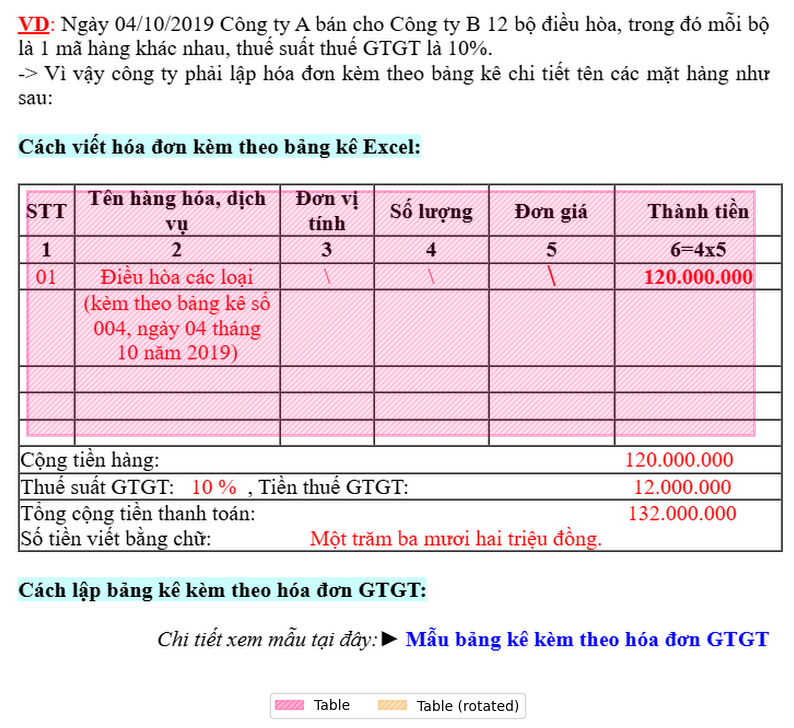

In [53]:
fig = visualize_detected_tables(image, objects)

In [54]:
visualized_image = fig2img(fig)

## Crop table

Next, we crop the table out of the image. For that, the TATR authors employ some padding to make sure the borders of the table are included.

In [55]:
def objects_to_crops(img, tokens, objects, class_thresholds, padding=10):
    """
    Process the bounding boxes produced by the table detection model into
    cropped table images and cropped tokens.
    """

    table_crops = []
    for obj in objects:
        if obj['score'] < class_thresholds[obj['label']]:
            continue

        cropped_table = {}

        bbox = obj['bbox']
        bbox = [bbox[0]-padding, bbox[1]-padding, bbox[2]+padding, bbox[3]+padding]

        cropped_img = img.crop(bbox)

        table_tokens = [token for token in tokens if iob(token['bbox'], bbox) >= 0.5]
        for token in table_tokens:
            token['bbox'] = [token['bbox'][0]-bbox[0],
                             token['bbox'][1]-bbox[1],
                             token['bbox'][2]-bbox[0],
                             token['bbox'][3]-bbox[1]]

        # If table is predicted to be rotated, rotate cropped image and tokens/words:
        if obj['label'] == 'table rotated':
            cropped_img = cropped_img.rotate(270, expand=True)
            for token in table_tokens:
                bbox = token['bbox']
                bbox = [cropped_img.size[0]-bbox[3]-1,
                        bbox[0],
                        cropped_img.size[0]-bbox[1]-1,
                        bbox[2]]
                token['bbox'] = bbox

        cropped_table['image'] = cropped_img
        cropped_table['tokens'] = table_tokens

        table_crops.append(cropped_table)

    return table_crops

In [56]:
objects

[{'label': 'table',
  'score': 0.9992853999137878,
  'bbox': [15.006417274475098,
   165.96971130371094,
   680.4815673828125,
   389.18621826171875]}]

In [57]:
tokens = []
detection_class_thresholds = {
    "table": 0.5,
    "table rotated": 0.5,
    "no object": 10
}
crop_padding = 10

tables_crops = objects_to_crops(image, tokens, objects, detection_class_thresholds, padding=0)
cropped_table = tables_crops[0]['image'].convert("RGB")
#cropped_table

In [58]:
#cropped_table.save("table.jpg")

## Load structure recognition model

Next, we load a Table Transformer pre-trained for table structure recognition.

In [59]:
from transformers import TableTransformerForObjectDetection

# new v1.1 checkpoints require no timm anymore
structure_model = TableTransformerForObjectDetection.from_pretrained("microsoft/table-structure-recognition-v1.1-all")
structure_model.to(device)
print("")

config.json:   0%|          | 0.00/76.8k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/115M [00:00<?, ?B/s]

We prepare the cropped table image for the model, and perform a forward pass.

In [60]:
structure_transform = transforms.Compose([
    MaxResize(1000),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [61]:
pixel_values = structure_transform(cropped_table).unsqueeze(0)
pixel_values = pixel_values.to(device)
print(pixel_values.shape)

torch.Size([1, 3, 335, 1000])


In [62]:
# forward pass
with torch.no_grad():
  outputs = structure_model(pixel_values)

Next, we get the predicted detections.

In [63]:
# update id2label to include "no object"
structure_id2label = structure_model.config.id2label
structure_id2label[len(structure_id2label)] = "no object"

cells = outputs_to_objects(outputs, cropped_table.size, structure_id2label)
print(cells)

[{'label': 'table column', 'score': 0.999930739402771, 'bbox': [43.40082931518555, 0.04771104454994202, 232.5540313720703, 213.8095703125]}, {'label': 'table row', 'score': 0.5822029709815979, 'bbox': [-0.030243098735809326, 199.1900177001953, 661.4894409179688, 216.4386444091797]}, {'label': 'table column', 'score': 0.9997010827064514, 'bbox': [426.7159423828125, 0.06079685688018799, 541.3145141601562, 215.27940368652344]}, {'label': 'table spanning cell', 'score': 0.7050492167472839, 'bbox': [-0.216354101896286, 66.07613372802734, 43.02061080932617, 212.0362548828125]}, {'label': 'table row', 'score': 0.9319139122962952, 'bbox': [0.0043204426765441895, 41.850242614746094, 661.769287109375, 65.7579574584961]}, {'label': 'table column', 'score': 0.9993847608566284, 'bbox': [541.771484375, 0.03489106893539429, 661.9317626953125, 215.12442016601562]}, {'label': 'table column header', 'score': 0.9646136164665222, 'bbox': [0.048198699951171875, -0.021851778030395508, 661.797607421875, 41.5

## Visualize cells

We can visualize all recognized cells using PIL's ImageDraw module.

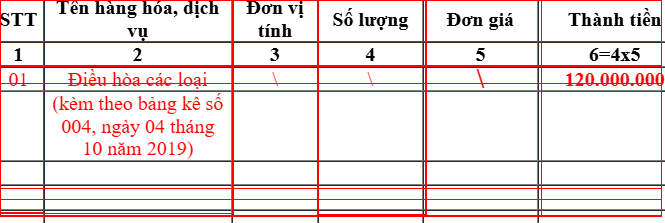

In [64]:
from PIL import ImageDraw

cropped_table_visualized = cropped_table.copy()
draw = ImageDraw.Draw(cropped_table_visualized)

for cell in cells:
    draw.rectangle(cell["bbox"], outline="red")

cropped_table_visualized

An alternative way of plotting is to select one class to visualize, like "table row":

In [65]:
def plot_results(cells, class_to_visualize):
    if class_to_visualize not in structure_model.config.id2label.values():
      raise ValueError("Class should be one of the available classes")

    plt.figure(figsize=(16,10))
    plt.imshow(cropped_table)
    ax = plt.gca()

    for cell in cells:
        score = cell["score"]
        bbox = cell["bbox"]
        label = cell["label"]

        if label == class_to_visualize:
          xmin, ymin, xmax, ymax = tuple(bbox)

          ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, fill=False, color="red", linewidth=3))
          text = f'{cell["label"]}: {score:0.2f}'
          ax.text(xmin, ymin, text, fontsize=15,
                  bbox=dict(facecolor='yellow', alpha=0.5))
          plt.axis('off')

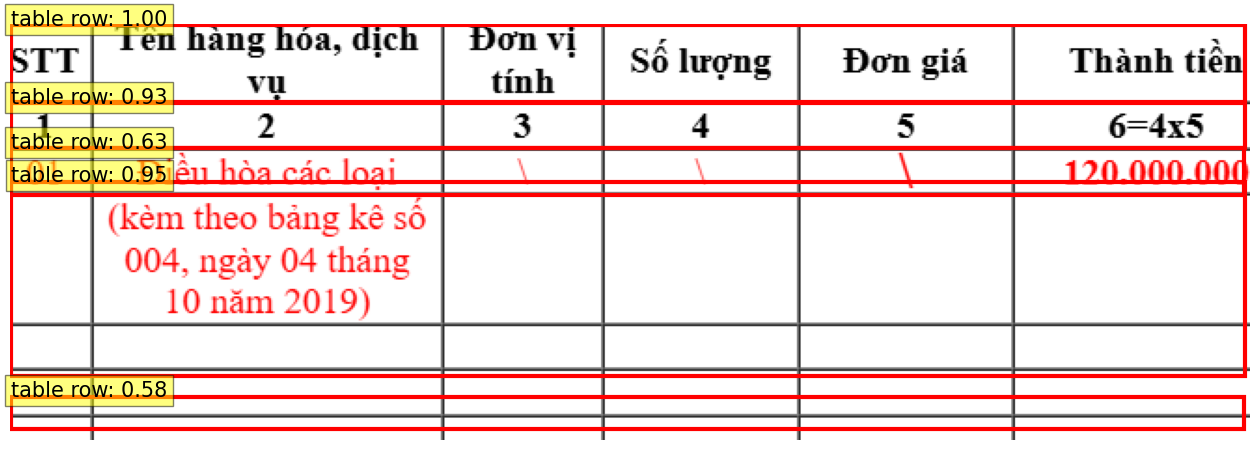

In [66]:
plot_results(cells, class_to_visualize="table row")

## Apply OCR row by row

First, we get the coordinates of the individual cells, row by row, by looking at the intersection of the table rows and columns (thanks ChatGPT!).

Next, we apply OCR on each individual cell, row-by-row.

Note that this makes some assumptions about the structure of the table: it assumes that the table has a rectangular, flat structure, containing a column header. One would need to update this for more complex table structures, potentially fine-tuning the detection and/or structure recognition model to be able to detect other layouts. Typically 50 labeled examples suffice for fine-tuning, but the more data you have, the better.

Alternatively, one could also do OCR column by column, etc.

In [67]:
def get_cell_coordinates_by_row(table_data):
    # Extract rows and columns
    rows = [entry for entry in table_data if entry['label'] == 'table row']
    columns = [entry for entry in table_data if entry['label'] == 'table column']

    # Sort rows and columns by their Y and X coordinates, respectively
    rows.sort(key=lambda x: x['bbox'][1])
    columns.sort(key=lambda x: x['bbox'][0])

    # Function to find cell coordinates
    def find_cell_coordinates(row, column):
        cell_bbox = [column['bbox'][0], row['bbox'][1], column['bbox'][2], row['bbox'][3]]
        return cell_bbox

    # Generate cell coordinates and count cells in each row
    cell_coordinates = []

    for row in rows:
        row_cells = []
        for column in columns:
            cell_bbox = find_cell_coordinates(row, column)
            row_cells.append({'column': column['bbox'], 'cell': cell_bbox})

        # Sort cells in the row by X coordinate
        row_cells.sort(key=lambda x: x['column'][0])

        # Append row information to cell_coordinates
        cell_coordinates.append({'row': row['bbox'], 'cells': row_cells, 'cell_count': len(row_cells)})

    # Sort rows from top to bottom
    cell_coordinates.sort(key=lambda x: x['row'][1])

    return cell_coordinates

cell_coordinates = get_cell_coordinates_by_row(cells)

In [68]:
len(cell_coordinates)

5

In [69]:
len(cell_coordinates[0]["cells"])

6

In [70]:
for row in cell_coordinates:
  print(row["cells"])

[{'column': [0.1186610609292984, 0.01963868737220764, 43.43117141723633, 213.25732421875], 'cell': [0.1186610609292984, 0.07584653794765472, 43.43117141723633, 41.44710159301758]}, {'column': [43.40082931518555, 0.04771104454994202, 232.5540313720703, 213.8095703125], 'cell': [43.40082931518555, 0.07584653794765472, 232.5540313720703, 41.44710159301758]}, {'column': [233.83502197265625, 0.18663066625595093, 317.8809814453125, 215.97962951660156], 'cell': [233.83502197265625, 0.07584653794765472, 317.8809814453125, 41.44710159301758]}, {'column': [318.61328125, 0.15323492884635925, 425.9938659667969, 214.55307006835938], 'cell': [318.61328125, 0.07584653794765472, 425.9938659667969, 41.44710159301758]}, {'column': [426.7159423828125, 0.06079685688018799, 541.3145141601562, 215.27940368652344], 'cell': [426.7159423828125, 0.07584653794765472, 541.3145141601562, 41.44710159301758]}, {'column': [541.771484375, 0.03489106893539429, 661.9317626953125, 215.12442016601562], 'cell': [541.771484

18533it [00:16, 1134.68it/s]
/usr/local/lib/python3.10/dist-packages/vietocr/tool/predictor.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.

  0%|          | 0/5 [00:00<?, ?it/s]

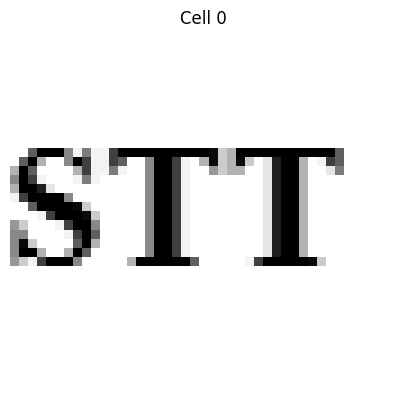

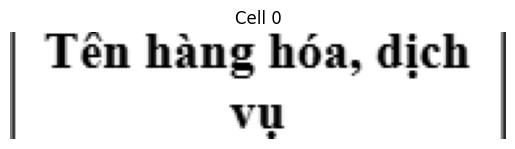

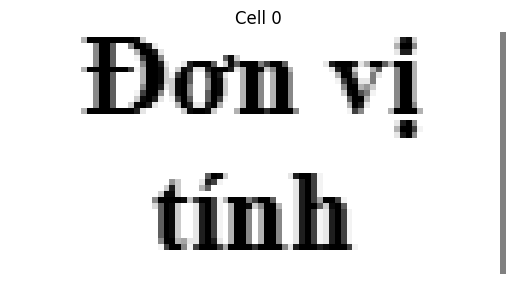

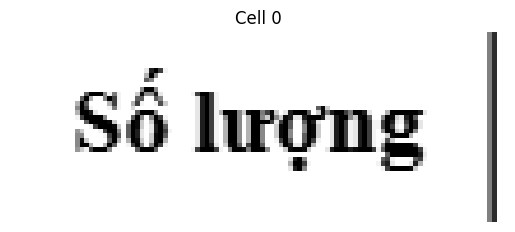

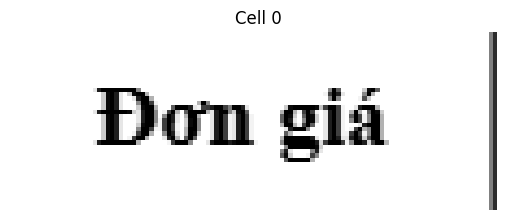

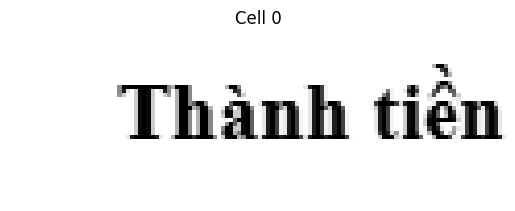

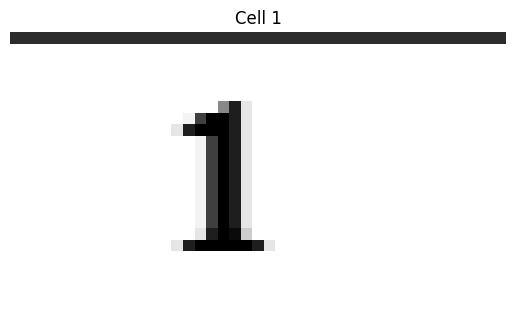

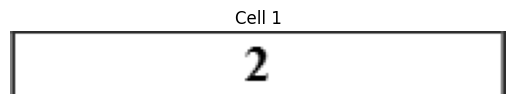

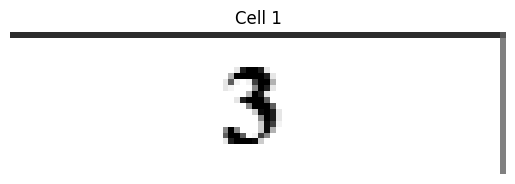

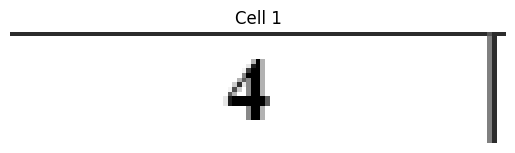

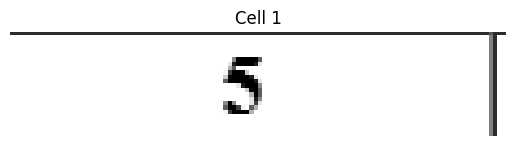

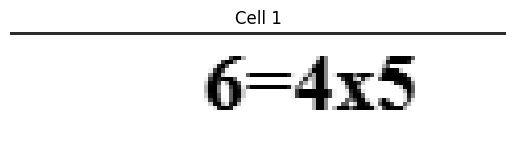

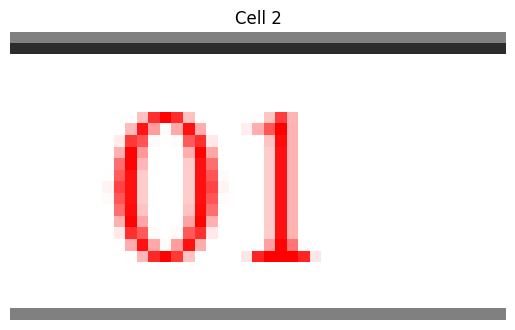

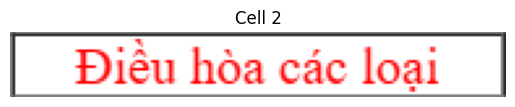

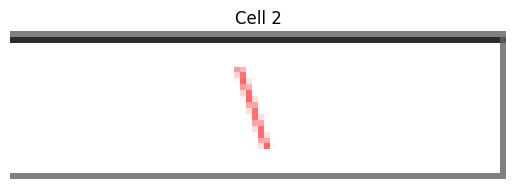

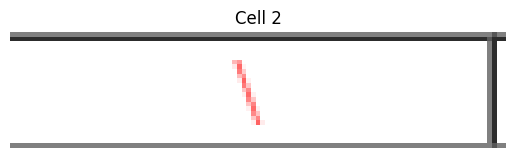

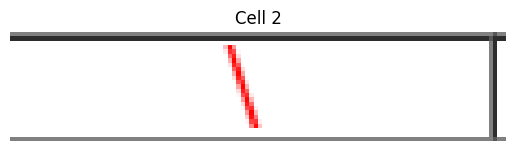

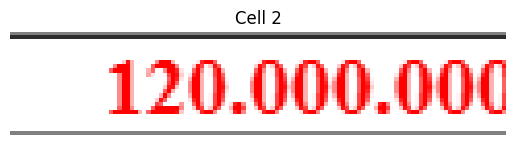

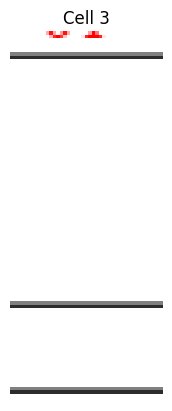

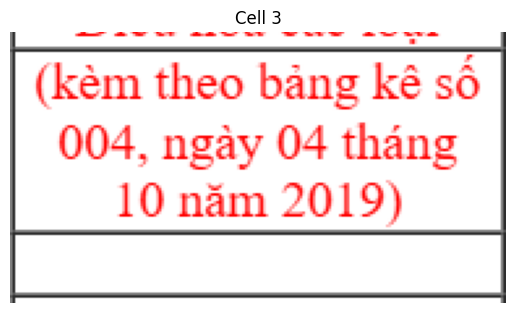

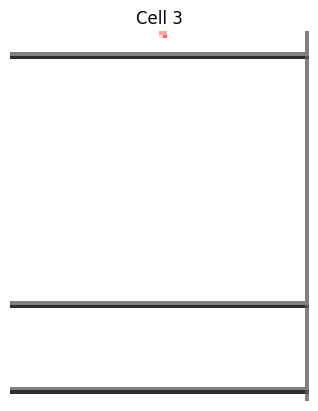

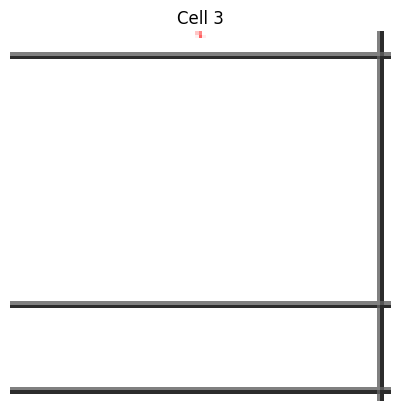

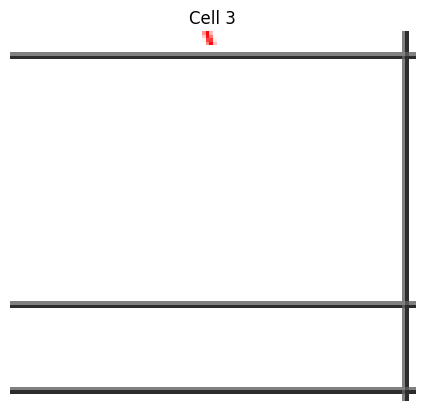

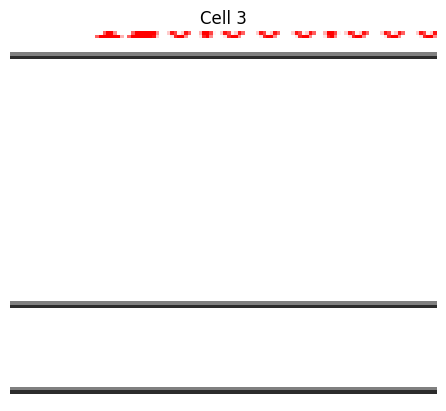

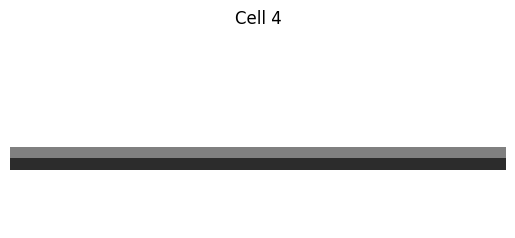

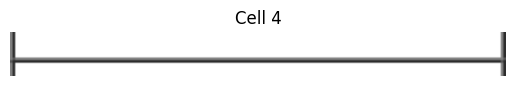

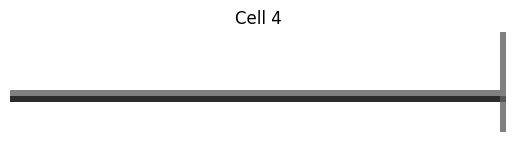

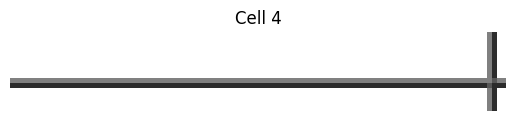

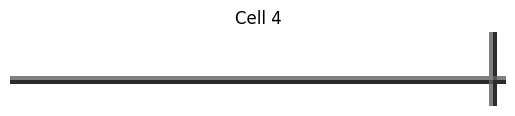

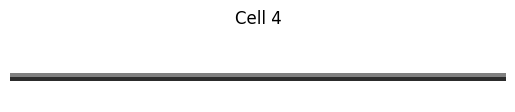

Số lượng cột lớn nhất: 6
['stt', 'Tên hàng hóa, dịch', 'Đơn v', 'Số lượng', 'Đơn giá', 'Thành tiền']
['1', '03819900199', '3', '4', '5', '6-4x5']
['01', 'Điều hòa các loại', 'STANK', 'STANDED', 'CONTRACTION', '120.000.000']
['03', '03900000099', '03000000099', '1', '1', '1']
['States', 'Contransitionalists', 'Contractional', '0310000000199', '0301000000191', '030100000001']


In [72]:

    import numpy as np
    import csv
    from tqdm.auto import tqdm
    from vietocr.tool.predictor import Predictor
    from vietocr.tool.config import Cfg


    # Khởi tạo bộ dự đoán của VietOCR
    config = Cfg.load_config_from_name('vgg_transformer')
    config['cnn']['pretrained'] = False
    config['device'] = 'cpu'
    predictor = Predictor(config)

    def apply_vietocr(cell_coordinates):
        # Thực hiện OCR từng hàng một
        data = dict()
        max_num_columns = 0
        for idx, row in enumerate(tqdm(cell_coordinates)):
            row_text = []
            for cell in row["cells"]:
                # Cắt ảnh ô ra khỏi ảnh gốc
                cell_image = np.array(cropped_table.crop(cell["cell"]))
                cell_image = Image.fromarray(cell_image)

                # Hiển thị ảnh cell_image
                plt.imshow(cell_image)
                plt.title(f"Cell {idx}")
                plt.axis('off')
                plt.show()

                # Áp dụng OCR
                text = predictor.predict(cell_image)

                if text:
                    row_text.append(text)

            if len(row_text) > max_num_columns:
                max_num_columns = len(row_text)

            data[idx] = row_text

        print("Số lượng cột lớn nhất:", max_num_columns)

        # Làm đầy các hàng không đủ cột để đảm bảo mỗi hàng có cùng số lượng cột
        for row, row_data in data.copy().items():
            if len(row_data) != max_num_columns:
                row_data = row_data + ["" for _ in range(max_num_columns - len(row_data))]
            data[row] = row_data

        return data

    data = apply_vietocr(cell_coordinates)

    for row, row_data in data.items():
        print(row_data)


## Save as CSV

We end up with a CSV file containing the data.

In [73]:
import csv

with open('output.csv','w') as result_file:
    wr = csv.writer(result_file, dialect='excel')

    for row, row_text in data.items():
      wr.writerow(row_text)

In [74]:
import pandas as pd

df = pd.read_csv("output.csv")
df.head()

,stt,"Tên hàng hóa, dịch",Đơn v,Số lượng,Đơn giá,Thành tiền
0,1,03819900199,3,4,5,6-4x5
1,01,Điều hòa các loại,STANK,STANDED,CONTRACTION,120.000.000
2,03,03900000099,03000000099,1,1,1
3,States,Contransitionalists,Contractional,0310000000199,0301000000191,030100000001
